## GNNs working on a different cohort 

In this notebook, we obtain the results for GNNs, baseline, and non-GNN models using a completely different cohort of Late Onset Alzheimer's Disease subjects and healthy controls.

The graph datasets were built using the network that obtained best performance in ADNI dataset (both with PET and PET&DX labellings), which is AD PPT-Ohmnet. 

*Disclaimer*: please note that many parts of this code require the preprocessed data from LOAD (both genetic and diagnostic related) as input. This data has not been uploaded to the repository for privacy reasons.

In [1]:
import numpy as np
import pandas as pd
import sys, os, datetime, pickle

from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import seaborn as sns
import matplotlib.pyplot as plt

from create_datasets import create_nx_datasets, create_splits
from create_datasets.create_table_datasets import load_data
from ml_models.utils import boxplot_comparison_models, statistics, barplot_comparison_models

/home/laura/anaconda3/envs/graphgym/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**1. Obtain genes of interest**

Using DisGeNET to get Gene-Disease-Associations (GDAs) to Alzheimer's Disease (AD gene set) and other neurodegenerative diseases (ND). This is already obtained from [first part of the results](1_main_methodology.ipynb).

**2. Obtain biological networks**

Using genes of interst obtained from DisGeNET, obtain PPI between them from STRING. This is already obtained from [first part of the results](1_main_methodology.ipynb).

**3. Data preprocessing**

Please refer to `data_preprocessing` subdirectory for this part.
1. [make_BED_files.R](data_preprocessing/make_BED_files.R) creates BED files with the genomic coordinates of the genes of interest. This is already obtained from [first part of the results](1_main_methodology.ipynb).
2. [extract_and_annotate_missense_LOAD.sh](data_preprocessing/extract_and_annotate_missense_LOAD.sh) is the script for obtaining missense variants from the VCF files.

**4. Create graph datasets**

Create graph datasets (one graph representing each patient) for different targets with LOAD dataset. As previously stated, we only obtain graph datasets using AD PPT-Ohmnet network (named as `snap_brain` in the following code).

In [3]:
networks = ['snap_brain']

for network in networks:

    outdir = f'data/graph_datasets/LOAD'

    start_time = datetime.datetime.now()
    print()

    result_nodes = create_nx_datasets.main('data', 'LOAD', 'LOAD', 'AD', network, 'missense', None)
    print('Coding: number of missense variants per node')

    outfile = f'{outdir}/AD_PPI_{network}_missense.pkl'
    print('Resulting dataset saved at:', outfile)
    print()

    with open(outfile, 'wb') as f:
        pickle.dump(result_nodes, f)

    result_nodes_time = datetime.datetime.now()
    print('Processing time:', result_nodes_time - start_time)
    print('\n\n')


Network used: AD snap_brain
# nodes = 29
# edges = 52

Dataset used: LOAD
(11, 1678)
(11, 1608)
missense
(29, 1599)
Creating samples graphs...
Class: LOAD. Found 1014 positive subjects out of 1599
Sample graph used: # nodes = 29 # edges = 52
Density = 0.12807881773399016 Diameter = 6
Coding: number of missense variants per node
Resulting dataset saved at: data/graph_datasets/LOAD/AD_PPI_snap_brain_missense.pkl

Processing time: 0:00:55.406044





**5. Graph classification with GNNs**

We then evaluated and tested different GNN configurations in the framework called [GraphGym](https://github.com/snap-stanford/GraphGym) (You *et al.*, 2020).

Configuration and grid files employed are in the subdirectory [graphgym_files](graphgym_files).

Summarized results obtained by GraphGym in LOAD dataset are in **COMPLETE**

We run GraphGym 10 times, with the 10 different splits generated by 10-Fold Stratified Cross-Validation (see below).

In [3]:
# Create split for using it in GraphGym and non-GNN models
# Splits are obtained through 10-Fold Stratied Cross Validation

create_splits.create_folds_stratified_cv('LOAD', 10)

LOAD
Fold -  1   |   train -  [526 913]   |   test -  [ 59 101]
Fold -  2   |   train -  [526 913]   |   test -  [ 59 101]
Fold -  3   |   train -  [526 913]   |   test -  [ 59 101]
Fold -  4   |   train -  [526 913]   |   test -  [ 59 101]
Fold -  5   |   train -  [526 913]   |   test -  [ 59 101]
Fold -  6   |   train -  [527 912]   |   test -  [ 58 102]
Fold -  7   |   train -  [527 912]   |   test -  [ 58 102]
Fold -  8   |   train -  [527 912]   |   test -  [ 58 102]
Fold -  9   |   train -  [527 912]   |   test -  [ 58 102]
Fold -  10   |   train -  [527 913]   |   test -  [ 58 101]



**6. Analyze results**

We obtained best GNN configurations in each split. Next, we selected the common configuration in all splits and obtained average and standard deviation over the 10 splits of several performance metrics (Accuracy, Precision, Recall, F1, AUC).

Please refer to the following notebook **COMPLETE!** to see how we compared GNNs performance against other non-GNN models and the corresponding baseline model.

## Compare with other non-GNN models

**1. Create table datasets**

Create table datasets for the LOAD target and genes of interest to use as input for more-standard machine learning models.

In [ ]:
# Input: type of variant, best network from previous analysis, missense data, diagnosis/metadata
table_dataset = load_data('missense',
                          'data/bio_networks/AD_SNAP_PPI_brain.edgelist',
                          'data/table_datasets/AD_snap_brain_missense_LOAD.csv',
                          'data/LOAD/LOAD_metadata.tsv')
table_dataset.to_csv(f'data/table_datasets/AD_PPI_missense_LOAD_labeled.csv')

**2. Baseline models - Logistic Regression only with APOE**

In [ ]:
target = 'LOAD'
    
result_df = pd.DataFrame(columns = ['fold', 'target', 'dataset', 'model', 'acc', 'pre', 'rec', 'f1', 'auc'])

data = pd.read_csv('data/table_datasets/AD_PPI_missense_LOAD_labeled.csv', index_col = 0)
data_wclass = create_class_LOAD(data)

x = data_wclass.drop(columns=['y'])
x = x['APOE']

y = data_wclass['y']
x.index = x.index.str.upper()

for i in range(10):

    i += 1

    f = open(f'data/splits/10Fold_CV_{target}/k{i}_{target}.pkl', 'rb')
    split = pickle.load(f)
    f.close()

    tr_idx = split['train']
    te_idx = split['valid']

    x_train, x_test = x.iloc[tr_idx], x.iloc[te_idx]
    y_train, y_test = y[tr_idx], y[te_idx]

    x_train = np.array(x_train).reshape(-1, 1)
    x_test = np.array(x_test).reshape(-1, 1)

    scaler = preprocessing.StandardScaler().fit(x_train)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    logreg = LogisticRegression()
    logreg.fit(x_train_scaled, y_train)

    y_prob = logreg.predict_proba(x_test_scaled)

    y_pred = logreg.predict(x_test_scaled)
    acc = metrics.accuracy_score(y_test, y_pred)
    pre = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1  = metrics.f1_score(y_test, y_pred)
    auc = metrics.roc_auc_score(y_test, y_prob[:, 1])

    result_df.loc[len(result_df)] = [i, target, 'Only APOE', 'Baseline model', acc, pre, rec, f1, auc]

result_df.to_csv(f'results/2022_03_baseline_models_{target}.csv', index=False)

**3. Other non-GNN models: Logistic Regression, SVM Linear, SVM RBF, Random Forest**

In [ ]:
target = 'LOAD'
        
data = pd.read_csv('data/table_datasets/AD_PPI_missense_LOAD_labeled.csv', index_col = 0)
data_wclass = create_class_LOAD(data) # label dataset with the corresponding label
data_wclass = data_wclass.loc[:, (data_wclass != 0).any(axis=0)] # delete genes that do not have mutations (all zeroes)
    
x = data_wclass.drop(columns=['y'])
y = data_wclass['y']
x.index = x.index.str.upper()

results = [] # list of lists that stores performance metrics
    
for i in range(10):

    i += 1

    print('Fold', i)
    print('-------------------------------------------------')

    f = open(f'data/splits/10Fold_CV_{target}/k{i}_{target}.pkl', 'rb')
    split = pickle.load(f)
    f.close()

    tr_idx = split['train']
    te_idx = split['valid']

    x_train, x_test = x.iloc[tr_idx], x.iloc[te_idx]
    y_train, y_test = y[tr_idx], y[te_idx]

    scaler = preprocessing.StandardScaler().fit(x_train)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # Logistic Regression
    logreg = LogisticRegression()
    logreg.fit(x_train_scaled, y_train)
    y_prob_logreg = logreg.predict_proba(x_test_scaled)
    y_pred_logreg = logreg.predict(x_test_scaled)
    results.append([i, target, 'AD PPT-Ohmnet', 'Logistic Regression',
                    metrics.accuracy_score(y_test, y_pred_logreg),
                    metrics.precision_score(y_test, y_pred_logreg),
                    metrics.recall_score(y_test, y_pred_logreg),
                    metrics.f1_score(y_test, y_pred_logreg),
                    metrics.roc_auc_score(y_test, y_prob_logreg[:, 1])])

    # SVM Linear
    svm_lin = SVC(probability=True)
    param_grid_svm_lin = [{'C': [0.01, 0.1, 1, 10, 100, 1000]}]
    grid_search_svm_lin = GridSearchCV(svm_lin, param_grid_svm_lin, cv=10, scoring='roc_auc', n_jobs = -1, verbose = 3)
    grid_search_svm_lin.fit(x_train_scaled, y_train)
    print(grid_search_svm_lin.best_estimator_)
    y_prob_svm_lin = grid_search_svm_lin.predict_proba(x_test_scaled)
    y_pred_svm_lin = grid_search_svm_lin.predict(x_test_scaled)
    results.append([i, target, 'AD PPT-Ohmnet', 'SVM Linear',
                    metrics.accuracy_score(y_test, y_pred_svm_lin),
                    metrics.precision_score(y_test, y_pred_svm_lin),
                    metrics.recall_score(y_test, y_pred_svm_lin),
                    metrics.f1_score(y_test, y_pred_svm_lin),
                    metrics.roc_auc_score(y_test, y_prob_svm_lin[:, 1])])

    # SVM RBF
    svm_rbf = SVC(probability=True, kernel='rbf')
    param_grid_svm_rbf = [{'C': [0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1]}]
    grid_search_svm_rbf = GridSearchCV(svm_rbf, param_grid_svm_rbf, cv=10, scoring='roc_auc', n_jobs = -1, verbose = 3)
    grid_search_svm_rbf.fit(x_train_scaled, y_train)
    print(grid_search_svm_rbf.best_estimator_)
    y_prob_svm_rbf = grid_search_svm_rbf.predict_proba(x_test_scaled)
    y_pred_svm_rbf = grid_search_svm_rbf.predict(x_test_scaled)
    results.append([i, target, 'AD PPT-Ohmnet', 'SVM RBF',
                    metrics.accuracy_score(y_test, y_pred_svm_rbf),
                    metrics.precision_score(y_test, y_pred_svm_rbf),
                    metrics.recall_score(y_test, y_pred_svm_rbf),
                    metrics.f1_score(y_test, y_pred_svm_rbf),
                    metrics.roc_auc_score(y_test, y_prob_svm_rbf[:, 1])])

    # Random Forest
    rf_clf = RandomForestClassifier()
    param_grid = [{'n_estimators': [50, 500, 5000]}]
    grid_search_rf = GridSearchCV(rf_clf, param_grid, cv=10, scoring='roc_auc', n_jobs = -1, verbose = 3)
    grid_search_rf.fit(x_train, y_train)
    print(grid_search_rf.best_estimator_)
    y_prob_rf = grid_search_rf.predict_proba(x_test)
    y_pred_rf = grid_search_rf.predict(x_test)
    results.append([i, target, 'AD PPT-Ohmnet', 'Random Forest',
                    metrics.accuracy_score(y_test, y_pred_rf),
                    metrics.precision_score(y_test, y_pred_rf),
                    metrics.recall_score(y_test, y_pred_rf),
                    metrics.f1_score(y_test, y_pred_rf),
                    metrics.roc_auc_score(y_test, y_prob_rf[:, 1])])

    print()
        
results_df = pd.DataFrame(results, columns=['fold', 'target', 'dataset', 'model', 'acc', 'pre', 'rec', 'f1', 'auc'])
results_df.to_csv(f'results/2022_03_nonGNN_models_{target}.csv', index=False)
results_df

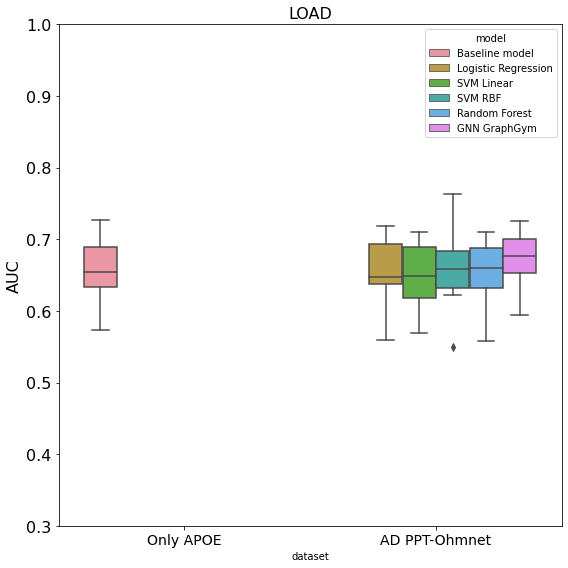

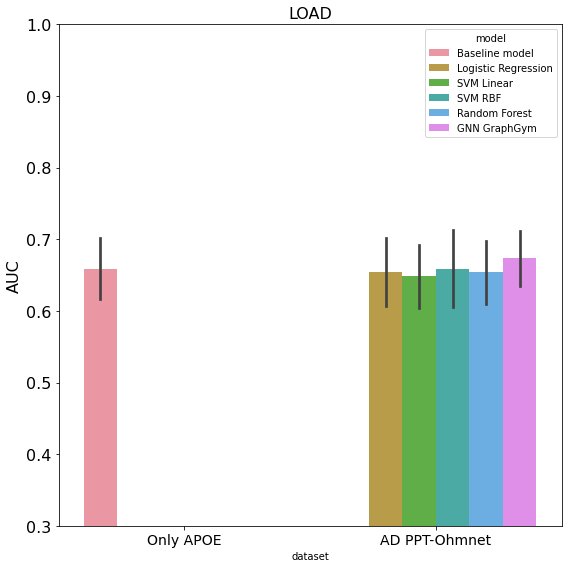

<Figure size 432x288 with 0 Axes>

In [2]:
load_nonGNN = pd.read_csv('results/2022_03_nonGNN_models_LOAD.csv', index_col='fold')
load_GNN    = pd.read_csv('results/2022_04_networks_LOAD.csv', index_col='fold')
load_bas    = pd.read_csv('results/2022_03_baseline_models_LOAD.csv',  index_col='fold')

load_all = pd.concat([load_nonGNN, load_GNN, load_bas])
boxplot_comparison_models('LOAD', load_all, 'auc', 'LOAD')
barplot_comparison_models('LOAD', load_all, 'auc', 'LOAD')

In [3]:
pvalues_bas_load, pvalues_ran_load = statistics(load_all)

Against baseline:
( ) 2.3507e-01 AD PPT-Ohmnet - GNN GraphGym
( ) 5.0101e-01 AD PPT-Ohmnet - SVM RBF
( ) 5.9103e-01 AD PPT-Ohmnet - Logistic Regression
( ) 5.9751e-01 AD PPT-Ohmnet - Random Forest
( ) 6.9812e-01 AD PPT-Ohmnet - SVM Linear
( ) nan AD PPT-Ohmnet no APOE - Logistic Regression
( ) nan AD PPT-Ohmnet no APOE - SVM Linear
( ) nan AD PPT-Ohmnet no APOE - SVM RBF
( ) nan AD PPT-Ohmnet no APOE - Random Forest
( ) nan AD PPT-Ohmnet no APOE - GNN GraphGym

Against random:
(*) 4.2666e-11 AD PPT-Ohmnet - GNN GraphGym
(*) 2.0959e-09 AD PPT-Ohmnet - Random Forest
(*) 3.8991e-09 AD PPT-Ohmnet - SVM Linear
(*) 7.6678e-09 AD PPT-Ohmnet - Logistic Regression
(*) 2.5141e-08 AD PPT-Ohmnet - SVM RBF
( ) nan AD PPT-Ohmnet no APOE - Logistic Regression
( ) nan AD PPT-Ohmnet no APOE - SVM Linear
( ) nan AD PPT-Ohmnet no APOE - SVM RBF
( ) nan AD PPT-Ohmnet no APOE - Random Forest
( ) nan AD PPT-Ohmnet no APOE - GNN GraphGym


In [28]:
load_all

,target,dataset,model,acc,pre,rec,f1,auc
fold,,,,,,,,
1,LOAD,AD PPT-Ohmnet,Logistic Regression,0.650000,0.747253,0.673267,0.708333,0.644403
1,LOAD,AD PPT-Ohmnet,SVM Linear,0.656250,0.705357,0.782178,0.741784,0.653298
1,LOAD,AD PPT-Ohmnet,SVM RBF,0.631250,0.631250,1.000000,0.773946,0.657157
1,LOAD,AD PPT-Ohmnet,Random Forest,0.637500,0.700935,0.742574,0.721154,0.656486
2,LOAD,AD PPT-Ohmnet,Logistic Regression,0.650000,0.752809,0.663366,0.705263,0.651452
2,LOAD,AD PPT-Ohmnet,SVM Linear,0.656250,0.709091,0.772277,0.739336,0.614197
2,LOAD,AD PPT-Ohmnet,SVM RBF,0.650000,0.752809,0.663366,0.705263,0.626615
2,LOAD,AD PPT-Ohmnet,Random Forest,0.656250,0.709091,0.772277,0.739336,0.626280
3,LOAD,AD PPT-Ohmnet,Logistic Regression,0.675000,0.737864,0.752475,0.745098,0.638530


In [4]:
mean_load = pd.DataFrame()
mean_load['dataset'] = load_all['dataset']
mean_load['model'] = load_all['model']
mean_load['mean_acc'] = load_all.groupby(['dataset', 'model'])['acc'].transform('mean')
mean_load['std_acc'] = load_all.groupby(['dataset', 'model'])['acc'].transform('std')
mean_load['mean_pre'] = load_all.groupby(['dataset', 'model'])['pre'].transform('mean')
mean_load['std_pre'] = load_all.groupby(['dataset', 'model'])['pre'].transform('std')
mean_load['mean_rec'] = load_all.groupby(['dataset', 'model'])['rec'].transform('mean')
mean_load['std_rec'] = load_all.groupby(['dataset', 'model'])['rec'].transform('std')
mean_load['mean_f1']  = load_all.groupby(['dataset', 'model'])['f1'].transform('mean')
mean_load['std_f1']  = load_all.groupby(['dataset', 'model'])['f1'].transform('std')
mean_load['mean_auc'] = load_all.groupby(['dataset', 'model'])['auc'].transform('mean')
mean_load['std_auc'] = load_all.groupby(['dataset', 'model'])['auc'].transform('std')
mean_load = mean_load.drop_duplicates()

mean_load['acc_format'] = round(mean_load["mean_acc"], 4).map(str) + ' ± ' + round(mean_load["std_acc"], 4).map(str)
mean_load['pre_format'] = round(mean_load["mean_pre"], 4).map(str) + ' ± ' + round(mean_load["std_pre"], 4).map(str)
mean_load['rec_format'] = round(mean_load["mean_rec"], 4).map(str) + ' ± ' + round(mean_load["std_rec"], 4).map(str)
mean_load['f1_format']  = round(mean_load["mean_f1"], 4).map(str) + ' ± ' + round(mean_load["std_f1"], 4).map(str)
mean_load['auc_format'] = round(mean_load["mean_auc"], 4).map(str) + ' ± ' + round(mean_load["std_auc"], 4).map(str)
mean_load[['dataset', 'model', 'acc_format', 'pre_format', 'rec_format', 'f1_format', 'auc_format']]

,dataset,model,acc_format,pre_format,rec_format,f1_format,auc_format
fold,,,,,,,
1,AD PPT-Ohmnet,Logistic Regression,0.6542 ± 0.0335,0.7353 ± 0.0261,0.7109 ± 0.0491,0.7222 ± 0.032,0.6541 ± 0.0505
1,AD PPT-Ohmnet,SVM Linear,0.6535 ± 0.04,0.6962 ± 0.035,0.8135 ± 0.0915,0.7472 ± 0.0373,0.6482 ± 0.0465
1,AD PPT-Ohmnet,SVM RBF,0.6485 ± 0.028,0.6747 ± 0.066,0.9131 ± 0.1413,0.7649 ± 0.0243,0.659 ± 0.0564
1,AD PPT-Ohmnet,Random Forest,0.6604 ± 0.0405,0.713 ± 0.0267,0.778 ± 0.0623,0.7431 ± 0.0373,0.6539 ± 0.0464
1,AD PPT-Ohmnet,GNN GraphGym,0.6523 ± 0.0486,0.6917 ± 0.1004,0.7781 ± 0.0928,0.7236 ± 0.0797,0.6733 ± 0.0409
1,Only APOE,Baseline model,0.6648 ± 0.0397,0.7662 ± 0.0341,0.6784 ± 0.0466,0.7191 ± 0.0373,0.6591 ± 0.0451


## Comparison LOAD vs ADNI results

In [54]:
pet_GNN     = pd.read_csv('results/2022_03_networks_PET.csv', index_col='fold')
pet_bas     = pd.read_csv('results/2022_03_baseline_models_PET.csv',  index_col='fold')
petdx_GNN   = pd.read_csv('results/2022_03_networks_PETandDX.csv', index_col='fold')
petdx_bas   = pd.read_csv('results/2022_03_baseline_models_PETandDX.csv',  index_col='fold')
load_GNN    = pd.read_csv('results/2022_04_networks_LOAD.csv', index_col='fold')
load_bas    = pd.read_csv('results/2022_03_baseline_models_LOAD.csv',  index_col='fold')

all_labels = pd.concat([pet_GNN, pet_bas, petdx_GNN, petdx_bas, load_GNN, load_bas])
all_labels = all_labels.loc[(all_labels['dataset'] == 'AD PPT-Ohmnet') |
              (all_labels['dataset'] == 'Only APOE')]

results = all_labels.replace({'Only APOE': 'Only APOE - Baseline model',
                          'AD PPT-Ohmnet': 'AD PPT-Ohmnet - GNN GraphGym'})

Text(0, 0.5, 'AUC')

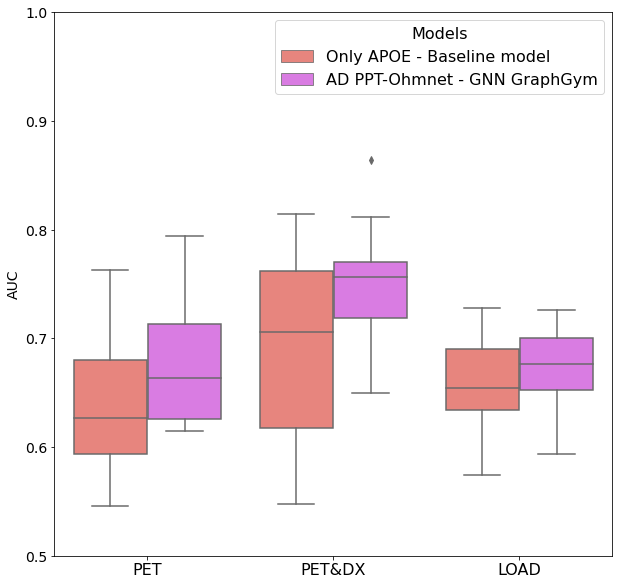

In [58]:
colors = ["#F8766D", "#E76BF3"]
custom = sns.set_palette(sns.color_palette(colors))
plt.figure(figsize=(10, 10))
sns.boxplot(x='target',
            y='auc',
            data=results,
            hue='dataset',
            hue_order=['Only APOE - Baseline model', 'AD PPT-Ohmnet - GNN GraphGym'],
            order=['PET', 'PET&DX', 'LOAD'],
            palette=custom) 
plt.xticks(fontsize=16)
plt.ylim(0.5, 1)
plt.yticks(fontsize=14)
plt.legend(title='Models', title_fontsize=16, fontsize=16)
plt.xlabel('', fontsize=1)
plt.ylabel('AUC', fontsize=14)

<AxesSubplot:xlabel='dataset', ylabel='auc'>

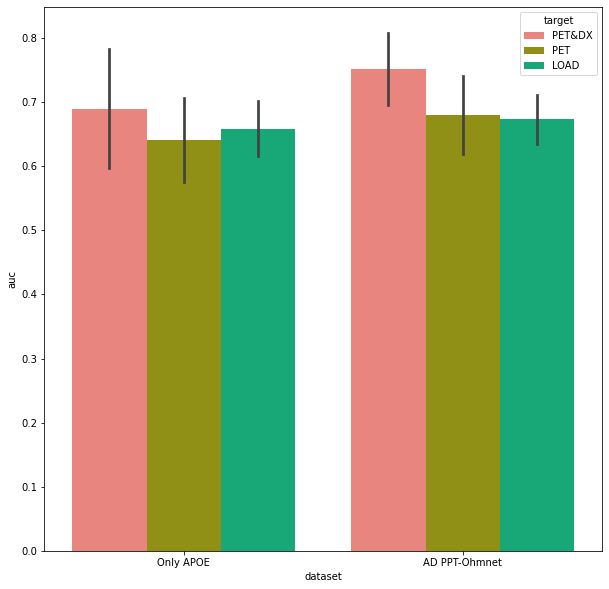

In [19]:
plt.figure(figsize=(10, 10))
sns.barplot(x='dataset', y='auc', data=all_labels, hue='target',
            order=['Only APOE', 'AD PPT-Ohmnet'], hue_order=['PET&DX', 'PET', 'LOAD'], ci='sd') 